This post is based on a pymc3 example called [A Hierarchical model for Rugby prediction](https://docs.pymc.io/notebooks/rugby_analytics.html) by Peadar Coyle. That work was inspired by [Daniel Weitzenfeld](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/), which in turn was based on a model first developed by [Gianluca Baio and Marta A. Blangiardo](http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf)

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import theano
from itertools import combinations

/home/everett/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# A function that retrieves the game data from the NHL stats API
# for a selected date range.
def request_game_data(start_date, end_date):
    base_url = 'https://statsapi.web.nhl.com'
    path = '/api/v1/schedule?startDate='+start_date+'&endDate='+end_date+'&expand=schedule.linescore'
    response = requests.get(base_url + path)
    return response.json()

# A function to extract the relevant data from the schedule
# and return it as a pandas dataframe
def extract_game_data(schedule):
    """Given full JSON records for games from the NHL API,
    returns a simplified list of just the data we need.
    """
    games = pd.DataFrame(columns=['date',
                                  'season',
                                  'game_type',
                                  'home_team',
                                  'home_team_reg_score',
                                  'home_team_fin_score',
                                  'away_team',
                                  'away_team_reg_score',
                                  'away_team_fin_score',
                                  'went_to_shoot_out'
                                  ])

    for date_obj in schedule['dates']:
        date = date_obj['date'];
        for game_obj in date_obj['games']:
            game_type = game_obj['gameType']
            season = game_obj['season']
            home_team_obj = game_obj['teams']['home']
            away_team_obj = game_obj['teams']['away']

            home_team = home_team_obj['team']['name']
            home_team_fin_score = home_team_obj['score']

            away_team = away_team_obj['team']['name']
            away_team_fin_score = away_team_obj['score']

            detailed_score_data = game_obj['linescore']
            period_data = detailed_score_data['periods']
            shootout_data = detailed_score_data['shootoutInfo']

            home_team_reg_score = 0
            away_team_reg_score = 0

            for period in period_data[0:3]:
                home_team_reg_score += period['home']['goals']
                away_team_reg_score += period['away']['goals']

            went_to_shoot_out = (shootout_data['home']['attempts'] != 0 or
                                 shootout_data['away']['attempts'] != 0)

            games = games.append({'date': date,
                                  'season': season,
                                  'game_type': game_type,
                                  'home_team': home_team,
                                  'home_team_reg_score': home_team_reg_score,
                                  'home_team_fin_score': home_team_fin_score,
                                  'away_team': away_team,
                                  'away_team_reg_score': away_team_reg_score,
                                  'away_team_fin_score': away_team_fin_score,
                                  'went_to_shoot_out': went_to_shoot_out
                                  }, ignore_index=True)

    return games

#completed_game_data = request_game_data('2016-09-18', '2018-03-15')
#completed_games = extract_game_data(completed_game_data)
#completed_games.to_csv('completed_games.csv', index = False)

#scheduled_game_data = request_game_data('2018-03-16', '2018-04-09')
#scheduled_games = extract_game_data(scheduled_game_data)
#scheduled_games.to_csv('scheduled_games.csv', index = False)

In [3]:
# Filter the data to just regular season games frm the 2015-2016 and 2016-2017 seasons 
completed_games = pd.read_csv('completed_games.csv')
completed_games = completed_games.loc[completed_games['game_type'] == 'R']

# Select the columns I need for this analysis
completed_games = completed_games[['home_team', 'away_team', 
                                   'home_team_reg_score', 'away_team_reg_score', 
                                   'home_team_fin_score', 'away_team_fin_score']]

# Extract the unique list of teams and assign an integer label to each one
teams = completed_games.home_team.unique()
teams = np.sort(teams)
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

# Create a unique list of each team combination and assign an integer label
# to each one. Also decide which team will be 'heads' in each pair.
all_teams_pair_combinations = combinations(teams['team'], 2)
team_pairs_dict = {}
team_pairs_heads_dict = {}
pair_index = 0
for pair in all_teams_pair_combinations:
    team_pairs_dict[(pair[0], pair[1])] = pair_index
    team_pairs_dict[(pair[1], pair[0])] = pair_index
    team_pairs_heads_dict[(pair[0], pair[1])] = pair[0]
    team_pairs_heads_dict[(pair[1], pair[0])] = pair[0]
    pair_index += 1

In [4]:
# Determine if the ultimate winner of the game was the heads team (Bernoulli outcome = True) 
# or the tails team (Bernoulli outcome = False)
def game_outcome_to_bernoulli_data(row):
    if row['home_team_fin_score'] > row['away_team_fin_score']:
        return row['home_team'] == team_pairs_heads_dict[(row['home_team'], row['away_team'])]
    return row['away_team'] == team_pairs_heads_dict[(row['home_team'], row['away_team'])]

# Modify the data to include team and pair integer labels
def add_team_data_labels(game_data):
    game_data = game_data.merge(teams, left_on='home_team', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_home'}).drop('team', axis=1)
    game_data = game_data.merge(teams, left_on='away_team', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_away'}).drop('team', axis=1)
    game_data['i_pair'] = game_data.apply(lambda row: team_pairs_dict[(row['home_team'], 
                                                                               row['away_team'])], axis=1)  
    game_data['i_pair_winner'] = game_data.apply(game_outcome_to_bernoulli_data, axis=1)
    
    return game_data
    
completed_games = add_team_data_labels(completed_games)

# Determine the total number of teams, team pairs, and games played
num_teams = len(completed_games.i_home.drop_duplicates())
num_team_pairs  = len(completed_games.i_pair.drop_duplicates())

# Create shaed theano variables that can be swapped out with
# scheduled games later.
home_team = theano.shared(completed_games.i_home.values)
away_team = theano.shared(completed_games.i_away.values)
team_pair = theano.shared(completed_games.i_pair.values)

# Create arrays of observations for our pymc3 model
observed_home_goals = completed_games.home_team_reg_score.values
observed_away_goals = completed_games.away_team_reg_score.values
observed_pair_outcomes = completed_games.i_pair_winner.values


In [5]:
with pm.Model() as model:
    # Global model parameters
    home = pm.Flat('home')
    sd_offence = pm.HalfStudentT('sd_offence', nu=3, sd=2.5)
    sd_defence = pm.HalfStudentT('sd_defence', nu=3, sd=2.5)
    intercept = pm.Flat('intercept')

    # Team-specific poisson model parameters
    offence_star = pm.Normal('offence_star', mu=0, sd=sd_offence, shape=num_teams)
    defence_star = pm.Normal('defence_star', mu=0, sd=sd_defence, shape=num_teams)
    offence = pm.Deterministic('offence', offence_star - tt.mean(offence_star))
    defence = pm.Deterministic('defence', defence_star - tt.mean(defence_star))
    home_theta = tt.exp(intercept + home + offence[home_team] - defence[away_team])
    away_theta = tt.exp(intercept + offence[away_team] - defence[home_team])

    # Team-pair binomial model parameters
    beta_a = np.array([1] * num_team_pairs)
    beta_b = np.array([1] * num_team_pairs)
    binom_p = pm.Beta('binom_p', alpha=beta_a, beta=beta_b, shape=num_team_pairs)
    
    # Likelihood of observed data
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=observed_home_goals)
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=observed_away_goals)
    tie_breaker = pm.Bernoulli('tie_breaker', p=binom_p[team_pair], observed=observed_pair_outcomes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [binom_p_logodds__, defence_star, offence_star, intercept, sd_defence_log__, sd_offence_log__, home]
100%|██████████| 3000/3000 [05:09<00:00,  9.70it/s]


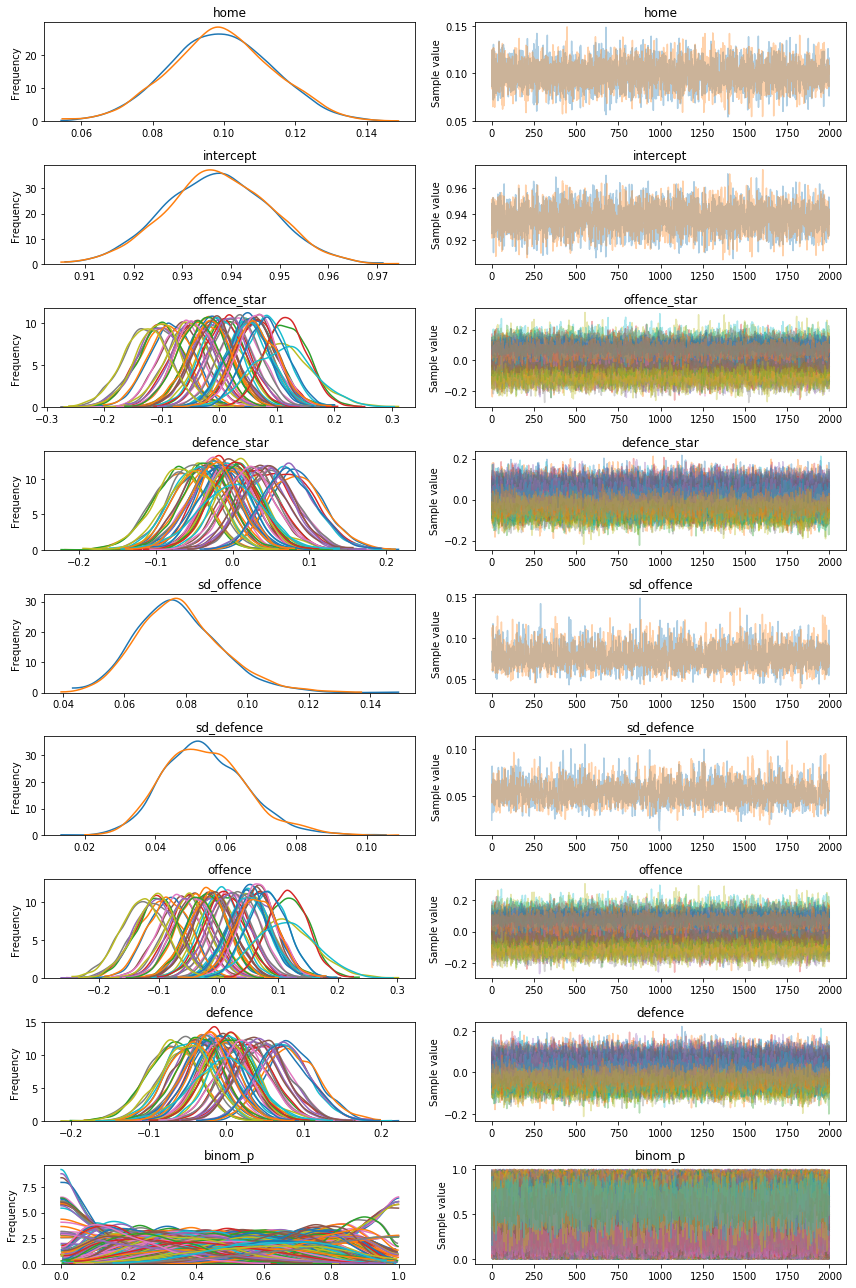

In [6]:
with model:
    trace = pm.sample(2000, tune=1000, cores=3)
    pm.traceplot(trace)

In [7]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

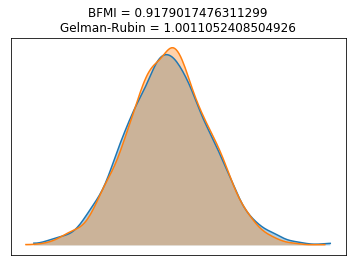

In [8]:
(pm.energyplot(trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

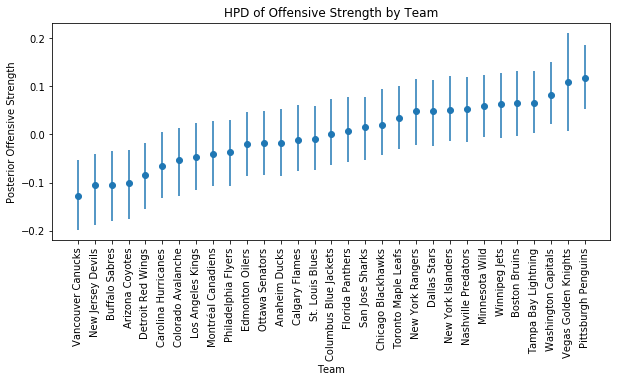

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

df_hpd = pd.DataFrame(pm.stats.hpd(trace['offence']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['offence'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Offensive Strength by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Offensive Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=90)

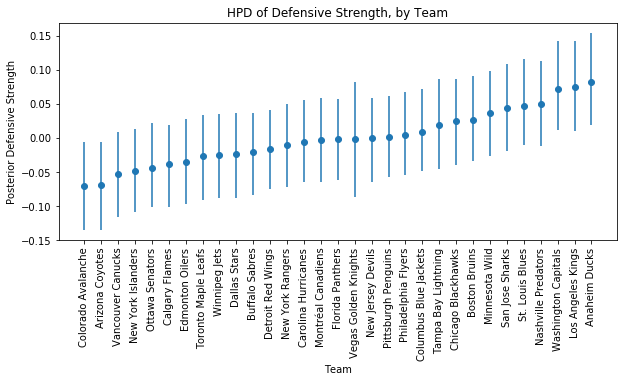

In [10]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['defence']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['defence'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Defensive Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defensive Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=90)

In [29]:
scheduled_games = pd.read_csv('scheduled_games.csv')
scheduled_games = scheduled_games.loc[scheduled_games['game_type'] == 'R']

# Select the columns I need for this analysis
scheduled_games = scheduled_games[['home_team', 'away_team', 
                                   'home_team_reg_score', 'away_team_reg_score', 
                                   'home_team_fin_score', 'away_team_fin_score']]

scheduled_games = add_team_data_labels(scheduled_games)

# Create shaed theano variables that can be swapped out with
# scheduled games later.
home_team.set_value(scheduled_games.i_home.values)
away_team.set_value(scheduled_games.i_away.values)
team_pair.set_value(scheduled_games.i_pair.values)

In [30]:
with model:
    post_pred = pm.sample_ppc(trace)

100%|██████████| 2000/2000 [00:02<00:00, 701.80it/s]


In [31]:
print(post_pred['away_goals'].shape)
print(post_pred['home_goals'].shape)
print(post_pred['tie_breaker'].shape)
print(scheduled_games.shape)

(2000, 181)
(2000, 181)
(2000, 181)
(181, 10)


In [120]:
home_won_regulation = post_pred['home_goals'] > post_pred['away_goals']
away_won_regulation = post_pred['away_goals'] > post_pred['home_goals']
regulation_tie = post_pred['home_goals'] == post_pred['away_goals']

home_won_tie_breaker = post_pred['tie_breaker'].copy()
away_won_tie_breaker = post_pred['tie_breaker'].copy()

# Determine if the home team is the heads team of the pair for the 181 remaining games
home_team_is_heads = np.array([(home_team == team_pairs_heads_dict[(home_team, away_team)]) for 
                               home_team, away_team in 
                               zip(scheduled_games['home_team'], scheduled_games['away_team'])])

home_won_tie_breaker = (home_won_tie_breaker == home_team_is_heads)
home_lost_tie_breaker = ~home_won_tie_breaker
away_won_tie_breaker = home_lost_tie_breaker
away_lost_tie_breaker = home_won_tie_breaker

In [121]:
home_team_sim_points = np.zeros_like(post_pred['home_goals'])
home_team_sim_points += 2 * home_won_regulation
home_team_sim_points += 2 * (regulation_tie & home_won_tie_breaker)
home_team_sim_points += 1 * (regulation_tie & home_lost_tie_breaker)

away_team_sim_points = np.zeros_like(post_pred['away_goals'])
away_team_sim_points += 2 * away_won_regulation
away_team_sim_points += 2 * (regulation_tie & away_won_tie_breaker)
away_team_sim_points += 1 * (regulation_tie & away_lost_tie_breaker)

In [122]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): points
        for i, points in enumerate(home_team_sim_points)
})
home_sim_df.insert(0, 'team', scheduled_games['home_team'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): points
        for i, points in enumerate(away_team_sim_points)
})
away_sim_df.insert(0, 'team', scheduled_games['away_team'])

In [123]:
home_sim_df.head()

,team,sim_points_0,sim_points_1,sim_points_10,sim_points_100,sim_points_1000,sim_points_1001,sim_points_1002,sim_points_1003,sim_points_1004,...,sim_points_990,sim_points_991,sim_points_992,sim_points_993,sim_points_994,sim_points_995,sim_points_996,sim_points_997,sim_points_998,sim_points_999
0,Washington Capitals,1,0,2,0,0,2,2,2,2,...,2,2,2,0,2,2,0,2,2,2
1,Ottawa Senators,2,0,0,2,2,2,2,2,0,...,2,2,2,0,2,2,2,0,2,0
2,Colorado Avalanche,1,2,2,2,2,0,0,2,0,...,1,0,0,0,0,2,2,0,0,2
3,Calgary Flames,2,2,0,2,2,0,1,0,0,...,1,0,1,0,2,0,0,0,2,1
4,Anaheim Ducks,2,0,2,2,1,2,2,0,2,...,2,0,0,2,2,1,2,0,0,2


In [125]:
away_sim_df.head()

,team,sim_points_0,sim_points_1,sim_points_10,sim_points_100,sim_points_1000,sim_points_1001,sim_points_1002,sim_points_1003,sim_points_1004,...,sim_points_990,sim_points_991,sim_points_992,sim_points_993,sim_points_994,sim_points_995,sim_points_996,sim_points_997,sim_points_998,sim_points_999
0,New York Islanders,2,2,1,2,2,0,1,0,0,...,0,0,0,2,0,1,2,0,0,0
1,Dallas Stars,0,2,2,0,0,0,0,0,2,...,0,0,0,2,1,0,0,2,0,2
2,Nashville Predators,2,0,1,0,0,2,2,0,2,...,2,2,2,2,2,0,0,2,2,0
3,San Jose Sharks,0,0,2,0,0,2,2,2,2,...,2,2,2,2,1,2,2,2,0,2
4,Detroit Red Wings,0,2,0,0,2,0,1,2,0,...,0,2,2,1,0,2,0,2,2,0


In [136]:
sim_table = (home_sim_df.groupby('team')
                        .sum()
                        .add(away_sim_df.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))

In [137]:
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0
team,,,,,,,,,,,,,,,,,,,,,
Anaheim Ducks,0.056,0.087,0.087,0.104,0.090,0.077,0.095,0.089,0.088,0.084,...,0.064,0.049,0.051,0.034,0.037,0.040,0.031,0.038,0.030,0.028
Arizona Coyotes,0.020,0.028,0.027,0.034,0.042,0.042,0.036,0.049,0.043,0.046,...,0.072,0.087,0.101,0.106,0.081,0.099,0.096,0.102,0.111,0.110
Boston Bruins,0.270,0.186,0.126,0.131,0.112,0.090,0.082,0.080,0.083,0.088,...,0.024,0.037,0.027,0.031,0.025,0.022,0.027,0.022,0.011,0.009
Buffalo Sabres,0.036,0.036,0.047,0.052,0.057,0.061,0.037,0.069,0.067,0.057,...,0.092,0.081,0.071,0.073,0.076,0.083,0.059,0.076,0.074,0.065
Calgary Flames,0.023,0.034,0.025,0.052,0.036,0.043,0.052,0.046,0.056,0.063,...,0.077,0.072,0.084,0.077,0.078,0.093,0.087,0.083,0.088,0.079
Carolina Hurricanes,0.055,0.062,0.053,0.062,0.063,0.065,0.061,0.071,0.061,0.086,...,0.075,0.074,0.075,0.069,0.054,0.064,0.062,0.056,0.050,0.046
Chicago Blackhawks,0.062,0.086,0.061,0.076,0.074,0.073,0.066,0.101,0.084,0.097,...,0.073,0.054,0.046,0.046,0.049,0.056,0.043,0.051,0.036,0.029
Colorado Avalanche,0.021,0.036,0.040,0.036,0.044,0.038,0.053,0.065,0.044,0.054,...,0.097,0.071,0.080,0.088,0.076,0.090,0.075,0.087,0.089,0.102
Columbus Blue Jackets,0.035,0.047,0.045,0.058,0.052,0.048,0.063,0.071,0.064,0.075,...,0.072,0.071,0.064,0.065,0.056,0.062,0.061,0.058,0.061,0.050


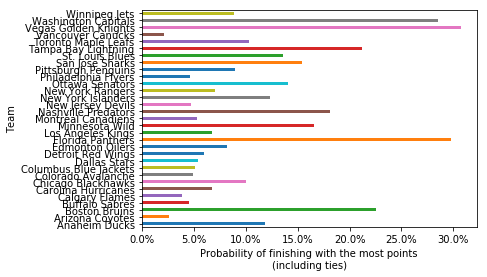

In [19]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points\n(including ties)");

ax.set_ylabel("Team");